# Semantic Segmentation

<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/master/examples/06_example_sematicsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/06_example_sematicsegmentation.ipynb" target="_blank"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"/></a>

_In order to run this notebook on a Kaggle platform, 1) click on the blue Kaggle badge saying Open in Kaggle 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the two blue checkboxes above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on Github, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the 
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

## About this demo
Semantic segmentation of tissue regions in histology images plays an important role in developing algorithms for cancer diagnosis and prognosis as it can help measure tissue attributes in an objective and reproducible fashion. In this example, we are showing how you can use pretrained segmentation models to do inference on a set of input images or WSIs. In this example, we first focus on a pretrained model incorporated in the tiatoolbox to achieve semantic annotation of tissue region in histology images of breast cancer. After that, we will explain how you can use your pretrained model in the tiatoolbox model inference pipeline to do prediction on a set WSIs.

### Setting up the environment
The cell below removes the directory `tmp` if it exists—a previous run may have created it. This cell can be skipped if you are running this notebook for the first time.

In [14]:
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )
import warnings
warnings.filterwarnings('ignore')

You can skip the following cell if 1) you are not using the Colab or Kaggle plaforms or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install git+https://github.com/TIA-Lab/tiatoolbox@develop | tail --line 1
ON_GPU = False
print('Installation is done.')

**[optional]**: if you are running this example notebook on your system and it is equipped with a Cuda enabled GPU, you can run the following cell to install Cuda enabled version of the torch package to utilize GPU computation and speed up the Tiatoolbox models.

In [4]:
# !pip install torch==1.8.2+cu102 torchvision==0.9.2+cu102 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html --user
# ON_GPU = True

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
     |████████████████████████████████| 804.1 MB 7.2 kB/s 
     |████████████████████████████████| 17.3 MB 1.4 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.8.2+cu102 which is incompatible.
tiatoolbox 0.7.0 requires torch==1.9.1, but you have torch 1.8.2+cu102 which is incompatible.
tiatoolbox 0.7.0 requires torchvision==0.10.1, but you have torchvision 0.9.2+cu102 which is incompatible.


### Importing related libraries

We import some standard Python modules, and also the Python module `wsireader` (see [details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)) written by the TIA Centre team.

In [16]:
from tiatoolbox.models.controller.semantic_segmentor import (IOSegmentorConfig,
                                                             SemanticSegmentor,
                                                             WSIStreamDataset,)
from tiatoolbox.utils.misc import imread
from tiatoolbox.wsicore.wsireader import get_wsireader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

mpl.rcParams['figure.dpi'] = 300 # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, image files used for the purpose of this notebook. In particular, we download a histology tile and a whole slide image of cancerous breast tissue samples to show how semantic segmentation models work. Also, pretrained weights of a Pytorch model and a small WSI are downloaded to illustrate how you can incorporate your own models in the existing Tiatoolbox segmentation tool.
> In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 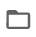

In [24]:
import requests

img_file_name = "sample_tile.jpg"
wsi_file_name = "sample_wsi.svs"
mini_wsi_file_name = "mini_wsi.svs"
model_file_name = "tissue_mask_model.pth"

print('Download has started. Please wait...')

# Downloading sample image tile
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/breast_tissue.jpg")
with open(img_file_name, "wb") as f:
    f.write(r.content)

# Downloading sample whole-slide image
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/breast_sample_wsi.svs") #
with open(wsi_file_name, "wb") as f:
    f.write(r.content)

# Downloading mini whole-slide image
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/CMU-1.ndpi") #
with open(mini_wsi_file_name, "wb") as f:
    f.write(r.content)

# Download external model
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk//models/seg/fcn-tissue_mask.pth")
with open(model_file_name, "wb") as f:
    f.write(r.content)

print('Download is complete.')

Download has started. Please wait...
Download is complete.


## Semantic segmentation using Tiatoolbox pretrained models
In this section, we will investigate the use of semantic segmentation models that have been already trained on a specific task and incorporated in the tiatoolbox.
Particularly, the model we are going to demonstrate can predict the probability of each pixel in an image (tile or whole slide images) of breast cancer sample belonging to one of the following classes:
- Tumour
- Stroma
- Inflammatory
- Necrosis
- Others (nerves, vessels, blood cells, adipose, etc.)

> More information about this categorization and the dataset we used for training on the mode can be found [here](https://academic.oup.com/bioinformatics/article/35/18/3461/5307750) (_Amgad et al., "Structured crowdsourcing enables convolutional segmentation of histology image"_) and the data is available for download using this [link](https://github.com/PathologyDataScience/BCSS).

### Inference on tiles
Much similar to the patch classifier functionality of the tiatoolbox, the semantic segmentation module works both on image tiles and structured WSIs. First, we need to create an instance of the  `SemanticSegmentor` class which controls the  whole process of semantic segmentation task and then use it to do prediction on the input image(s):

In [18]:
# Tile prediction
bcc_segmentor = SemanticSegmentor(
    pretrained_model="fcn_resnet50_unet-bcss",
    num_loader_workers=4, batch_size=4,
)

output = bcc_segmentor.predict(
        [img_file_name],
        save_dir="sample_tile_results/",
        mode="tile",
        resolution=1.0,
        units="baseline",
        patch_input_shape=[1024, 1024],
        patch_output_shape=[512, 512],
        # stride_shape=[512, 512],
        on_gpu=ON_GPU,
        crash_on_exception=True,
    )

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/seg/fcn_resnet50_unet-bcss.pth
Save to /root/.tiatoolbox/models/fcn_resnet50_unet-bcss.pth


Process Batch: 100%|############################| 16/16 [08:06<00:00, 30.38s/it]
|2021-10-21|17:59:37.492| [INFO] Finish: 0/1
|2021-10-21|17:59:37.493| [INFO] --Input: sample_tile.jpg
|2021-10-21|17:59:37.499| [INFO] --Ouput: /content/sample_tile_results/0


There we go! With only two lines of code, thousands of images can be processed automatically.
There are many parameters associated with `SemanticSegmentor` which we will explain their use throughout this notebook. Here we just explain the ones mentioned above:

- `pretrain_model`: specifies the name of the pretrained model included in the tiatoolbox (case sensitive). We are expanding our library of pretrained models on various segmentation tasks. You can find a complete list of available pretrained models [here](https://github.com/TIA-Lab/tiatoolbox/blob/develop/tiatoolbox/data/pretrained_model.yaml) and [here](https://github.com/TIA-Lab/tiatoolbox/blob/e190a0b9aa77222c8334f7eca8f3e8cd08ca285a/tiatoolbox/models/architecture/__init__.py#L51). In this example, we are using the `"fcn_resnet50_unet-bcss"` pretrained model, which is a fully convolutional network that follows [UNet](https://arxiv.org/abs/1505.04597) network architecture and benefits from a [ResNet50](https://arxiv.org/abs/1512.03385) model as its encoder part.

- `num_loader_workers`: as the name suggests, this parameter controls the number of CPU cores (workers) that are responsible for the "loading of network input" process, which consists of patch extraction, preprocessing, etc.

- `batch_size`: controls the batch size, or the number of input instances to the network in each iteration. If you are using GPU for the computations, you should be careful not to set the `batch_size` bigger than the amount that the GPU memory limit allows.

After the `bcc_segmentor` has been instantiated as a semantic segmentation controller with our desired pretrained model, one can call the `predict` method to do inference on a list of input images (or WSIs). The `predict` function, automatically process all the images in the input list and save the results on the disk. The process usually comprises patch extraction (because the whole tile or WSI won't fit into limited GPU memory), preprocessing, model inference, post-processing and prediction assembly. There some important parameters that should be set to properly use the `predict` method:

- `imgs`: List of inputs to be processed. Note that items in the list should be paths to the inputs stored on the disk.

- `save_dir`: Path to the main folder in which prediction results for each input will be stored separately.
 
- `mode`: the mode of inference which can be set to either `'tile'` or `'wsi'` for plain histology images or structured whole slides images, respectively.

- `resolution` and `unit`: specify the resolution on which we want to process the input. Because plain images only have baseline layer, `units="baseline"` and `resolution=1.0` options should be always kept like this when working in `'tile'` mode (these are function's default values, you can ignore setting them at all).

- `patch_input_shape`: the size of the patches extracted from the input image (WSI) to be fed into the model. The bigger the patch size the more GPU memory is needed.

- `patch_output_shape`: The expected size of output prediction maps for patches. This should be set based on the knowledge we have from the model design. For example, we know that the size out output maps from `"fcn_resnet50_unet-bcss"` model is half of the input size. Therefore, as we set the `patch_input_shape=1024`, we need to set the `patch_output_shape=512`.

- `stride_shape`: Stride of output patches during tile and WSI processing. This parameter is used to set the amount of overlap between neighbouring prediction patches. Based on this parameter, the toolbox automatically calculates the patch extraction stride.

- `on_gpu`: can be either `True` or `False` to dictate running the computations on GPU or CPU.

- `crash_on_exception`: If set to `True`, the running loop will crash if there is an error during processing a WSI, otherwise, the loop will move on to the next image (wsi) for processing. We suggest that you first make sure that the prediction is working as expected by testing it on a couple of inputs and then set this flag to `False` to process large cohorts of inputs.

In the `output`, the `prediction` method returns a list of the paths to its inputs and the processed outputs saved on the disk. Which can be used for loading the results in case you want to process or visualize them.

prediction method output is: [['sample_tile.jpg', '/content/sample_tile_results/0']]
Raw prediction dimensions: (4000, 4000, 5)
Processed prediction dimensions: (4000, 4000)
Input image dimensions: (4000, 4000, 3)


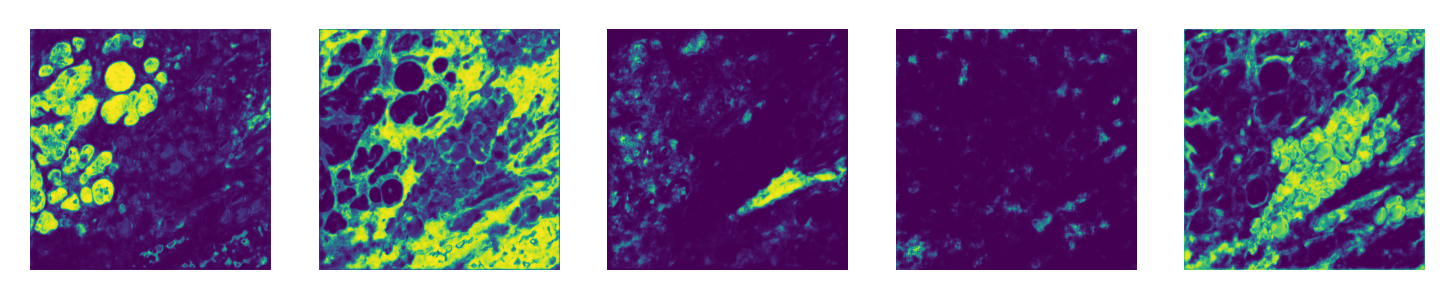

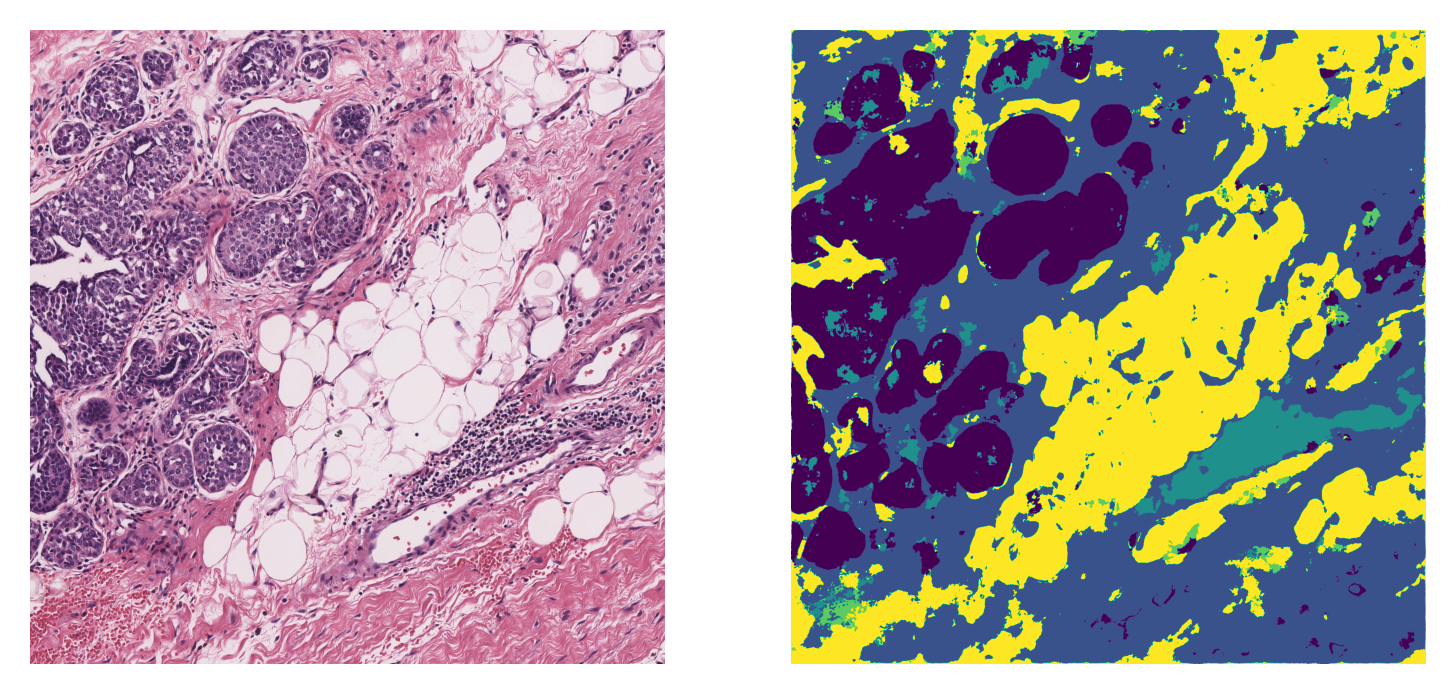

In [19]:
print('prediction method output is: {}'.format(output))
tile_prediction_raw = np.load(output[0][1]+'.raw.0.npy') # Loading the first prediction [0] based on the output address [1]
print('Raw prediction dimensions: {}'.format(tile_prediction_raw.shape))

# Simple processing of the raw prediction to generate semantic segmentation task
tile_prediction = np.argmax(tile_prediction_raw, axis=-1) # select the class with highest probability
print('Processed prediction dimensions: {}'.format(tile_prediction.shape))

# showing the predicted semantic segmentation
tile = imread(img_file_name)
print('Input image dimensions: {}'.format(tile.shape))

plt.figure(),
for i in range(5):
  ax = plt.subplot(1,5,i+1), plt.imshow(tile_prediction_raw[:, :, i]), plt.axis('off')

plt.figure(), # showing processed results
ax1 = plt.subplot(1,2,1), plt.imshow(tile), plt.axis('off')
ax2 = plt.subplot(1,2,2), plt.imshow(tile_prediction), plt.axis('off')


As printed above, the raw prediction array has 5 channels (size 4000x4000x**5**) which indicate the 5 categories that our segmentation model can distinguish. These prediction channels are illustrated in the first row, one-by-one, where each prediction map stands for a specific tissue region class. However, the idea is to have a single prediction map that contains specific values for each class. Therefore, we used a very simple post-processing technique to acquire the semantic segmentation map:
> `tile_prediction = np.argmax(tile_prediction_raw, axis=-1)`

that finds for each pixel the class index that has the highest value among all.

### Inference on WSIs
The next step is to use the Tiatoolbox's embedded model for region segmentation in a whole slide image. The process is quite similar to what we have done for tiles, we don't even need to instantiate a new `SemanticSegmentor`. The only thing you need to do is to set the parameters for the prediction function:

In [20]:
# WSI prediction
bcc_segmentor = SemanticSegmentor(
    pretrained_model="fcn_resnet50_unet-bcss",
    num_loader_workers=4, batch_size=4,
    auto_generate_mask=True
)

wsi_output = bcc_segmentor.predict(
        imgs=[wsi_file_name],
        masks=None,
        save_dir="sample_wsi_results/",
        mode="wsi",
        on_gpu=ON_GPU,
        crash_on_exception=True,
    )

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/seg/fcn_resnet50_unet-bcss.pth
Save to /root/.tiatoolbox/models/fcn_resnet50_unet-bcss.pth


Process Batch: 100%|############################| 64/64 [36:01<00:00, 33.78s/it]
|2021-10-21|18:36:01.287| [INFO] Finish: 0/1
|2021-10-21|18:36:01.291| [INFO] --Input: sample_wsi.svs
|2021-10-21|18:36:01.293| [INFO] --Ouput: /content/sample_wsi_results/0


Note the only differences made here are:
1. Adding `auto_generate_mask=True` to the `SemanticSegmentor` which tells the toolbox to automatically generate tissue masks from WSIs if there is not `masks` input to the `predict` function.
2. Setting `mode='wsi'` in the `predict` function indicates that we are predicting regions segmentations for inputs in the form of WSIs.
3. `masks=None` in the `predict` function. `masks` argument similar to the `imgs` should be a list of paths to the desired image masks. Patches from `imgs` are only processed if they are within a masked area of their corresponding `masks`. If not provided (`masks=None`), then a tissue mask will be automatically generated for whole-slide images or the entire image is processed for image tiles.

It might take a while to process, especially if you have set `ON_GPU=False`. The processing time depends on the size of the input WSI and the selected resolution. Here, we have not specified any values, which means that the `baseline` resolution of the WSI, which is 40x in this example, will be used.

prediction method output is: [['sample_wsi.svs', '/content/sample_wsi_results/0']]
Raw prediction dimensions: (4008, 4008, 5)
Processed prediction dimensions: (4008, 4008)
WSI overview dimensions: (4008, 4008)


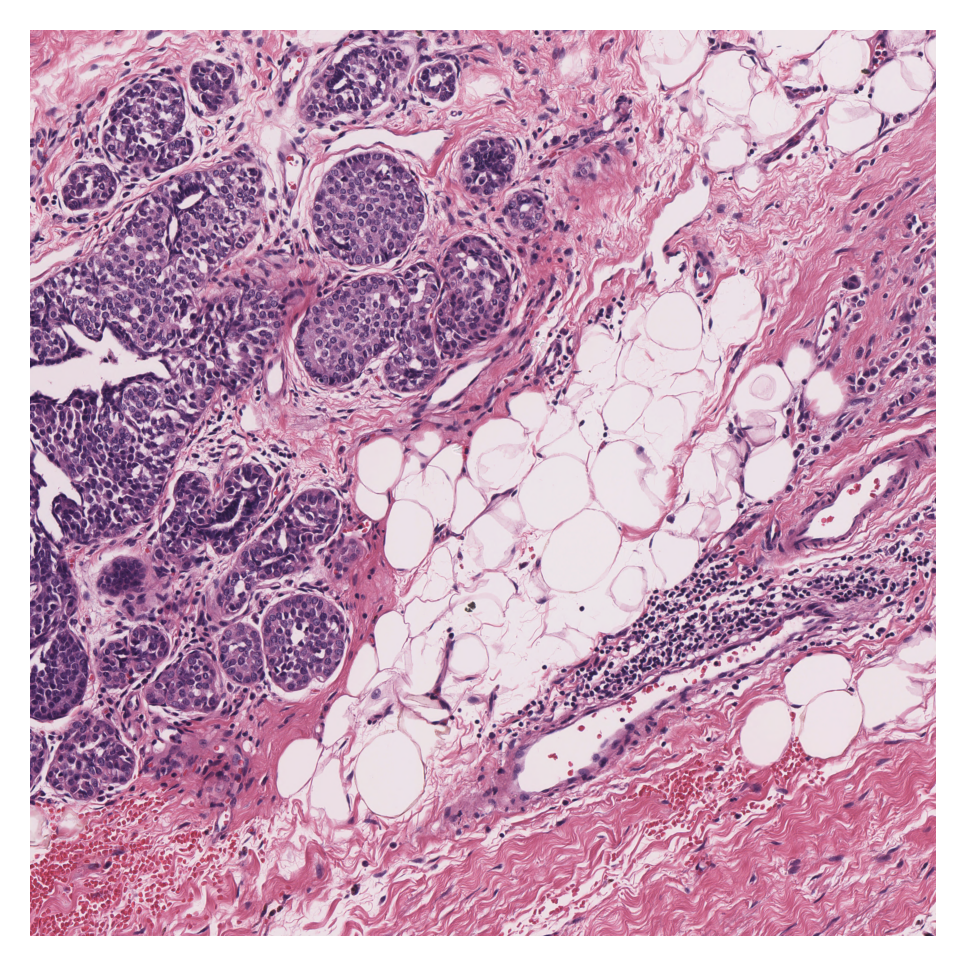

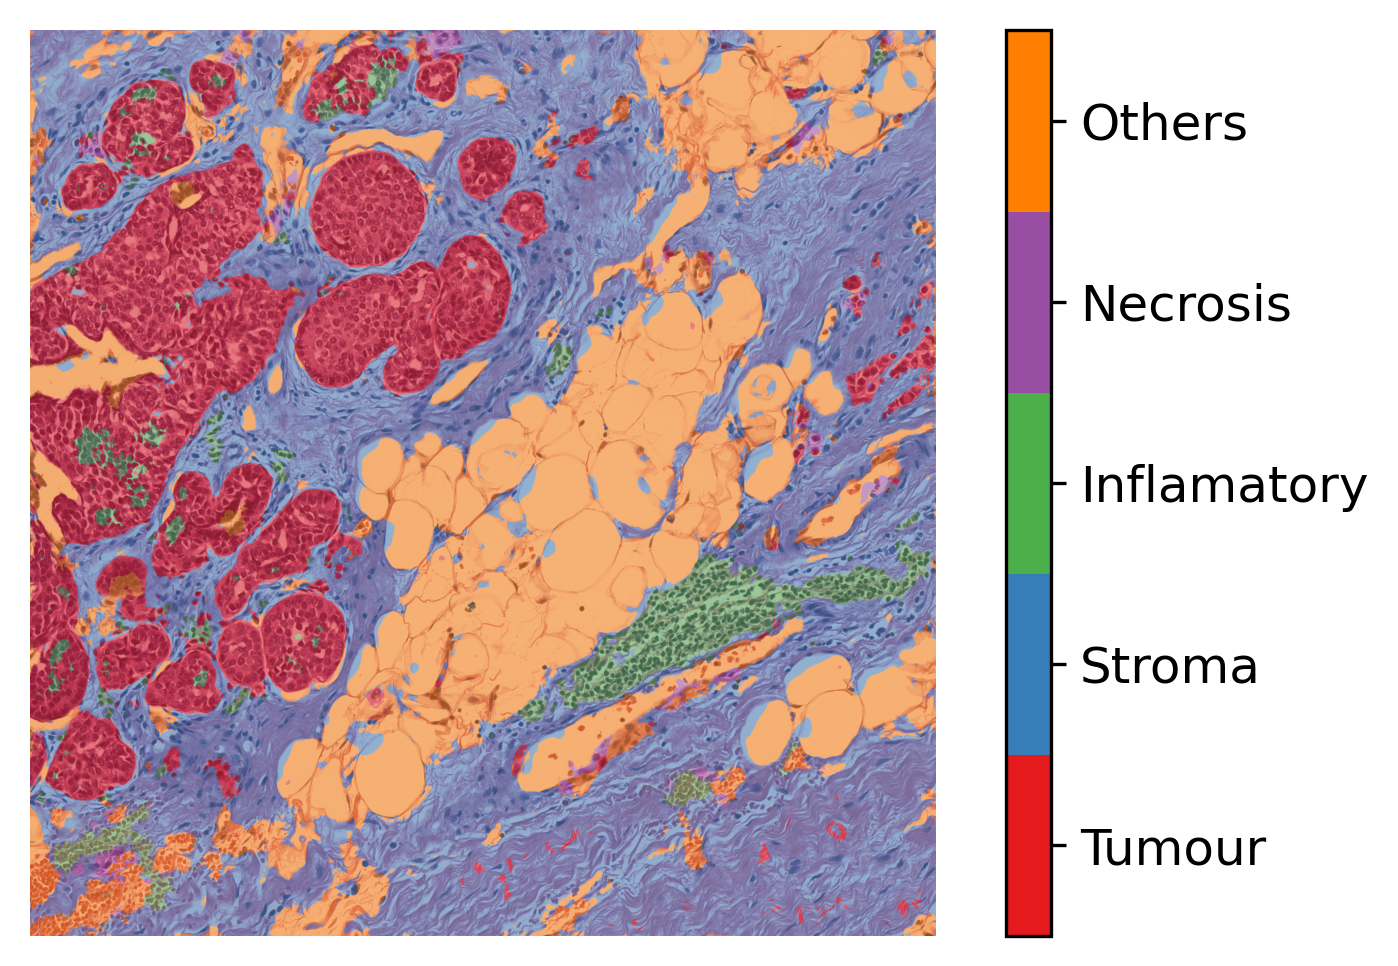

In [21]:
from matplotlib import cm
from tiatoolbox.utils.visualization import overlay_patch_prediction

print('prediction method output is: {}'.format(wsi_output))
wsi_prediction_raw = np.load(wsi_output[0][1]+'.raw.0.npy') # Loading the first prediction [0] based on the output address [1]
print('Raw prediction dimensions: {}'.format(wsi_prediction_raw.shape))

# [Post-processing]
# Simple processing of the raw prediction to generate semantic segmentation task
wsi_prediction = np.argmax(wsi_prediction_raw, axis=-1) # select the class with highest probability
print('Processed prediction dimensions: {}'.format(wsi_prediction.shape))

# [WSI overview extraction]
# Now reading the WSI to extract it's overview
wsi = get_wsireader(wsi_file_name)
# using the prediction save_resolution to create the wsi overview at the same resolution
overview_info = bcc_segmentor.ioconfig.save_resolution
# extracting slide overview using `slide_thumbnail` method
wsi_overview = wsi.slide_thumbnail(resolution=overview_info['resolution'], units=overview_info['units'])
print('WSI overview dimensions: {}'.format(wsi_prediction.shape))
plt.figure(), plt.imshow(wsi_overview); plt.axis('off')

# [Overlay map creation]
# creating label-color dictionary to be fed into `overlay_patch_prediction` function to help generating color legend
label_dict = {'Tumour': 0, 'Stroma': 1, 'Inflamatory': 2, 'Necrosis':3, 'Others':4}
label_color_dict = {}
colors = cm.get_cmap('Set1').colors
for class_name, label in label_dict.items():
    label_color_dict[label] = (class_name, 255*np.array(colors[label]))
# Creat overlay map using thhe `overlay_patch_prediction` helper function
overlay = overlay_patch_prediction(wsi_overview, wsi_prediction, alpha=0.5, label_info=label_color_dict)

As you can see above, we first post-process the prediction map, the same way we did for tiles (taking `argmax` of model output), to create the semantic segmentation map. Then, in order to visualise the segmentation prediction on the tissue image, we read the processed WSI and extracted its overview. Please note that the overview has been extracted at the same resolution as the prediction output has been saved in (which was accessed through `bcc_segmentor.ioconfig.save_resolution`). Finally, we used `overlay_patch_prediction` helper function of the Tiatoolbox to overlay the prediction map on the overview image and depict it with a colour legend.

In summary, it is very easy to use pretrained models in the Tiatoolbox to do predefined tasks. In fact, you don't even need to set any parameters related to model’s input/output when you are selecting to work with one of Tiatoolbox’s pretrained models (they will be set automatically based on their optimal values) and here we just show the parameters to explain how they work. In other words, region segmentation in images can be done as easy as:
```
segmentor = SemanticSegmentor(pretrained_model="fcn_resnet50_unet-bcss" num_loader_workers=4, batch_size=4)
output = segmentor.predict([img_file_name], save_dir="sample_tile_results/", mode="tile")
```

Having said that, you may need to take care of a couple of other things if you want to use the same model with new weights, or even use a whole new model in the Tiatoolbox inference pipeline. But don't worry, these will be covered in the next section of this example notebook.

## Semantic segmentation using user-trained (external) models
Although we at TIACentre are trying to extend the number of pretrained models in the toolbox every day to cover more tasks and tissue types, users can use their own models in the Tiatoolbox inference pipeline. It means that a researcher in computational pathology does not need to worry about programing for WSI processing, patch extraction, prediction aggregation, and multi-processing handling. Things even get more complicated when you want to do projects at scale. Here comes Tiatoolbox to rescue!
Tiatoolbox supports **Pytorch** models. It's very easy to fit torch models in the Tiatoolbox inference pipeline and we will show you how you can do that. 

### Tissue segmentation model as an external model
We have a model that has been trained for tissue mask segmentation i.e., a PyTorch model that has been trained to distinguish between tissue and background and we want to use it for tissue mask generation (instead of using a simple thresholding technique like Otsu's method).

The first thing to do is to prepare our model. Here we use a generic UNet architecture that already been implemented in the Tiatoolbox and load our pretrained weight more tissue segmentation into it (wights are already downloaded in the "Download" section). 

In [22]:
from tiatoolbox.models.architecture.unet import UNetModel

# define model architecture
external_model = UNetModel(
    num_input_channels = 3, # number of input image channels (3 for RGB)
    num_output_channels = 2, # number of model's output channels. 2 for two classes forground and background.
    encoder = "resnet50", # model used in the encoder part of the model to extract features
    decoder_block = [3] #  A list of convolution layers (each item specifies the kernel size)
)

# Loading pretrained weights into the model
map_location = torch.device('cuda') if ON_GPU else torch.device('cpu')
pretrained_weights = torch.load(model_file_name, map_location=torch.device('cpu'))
external_model.load_state_dict(pretrained_weights) 

<All keys matched successfully>

Remember this is just an example CNN model, you can use any model of your choice, just remember that in order to use that model in the `SemanticSegmentor`, model weight should be already loaded because when you pass a `model` argument to the `SemanticSegmentor`, it ignores the `pretrained_model` and `pretrained_weights` arguments (remember not to confuse that `pretrained_weights` is associated with `pretrained_model` not `model`).

Very well, not that we have our model in place, let's create our segment. Also, we need to configure the Input/Output stream of data for our model. Fortunately, there is a class dedicated to this matter in the `semantic_segmentor` controller module of Tiatoolbox, called `IOSegmentorConfig`:

In [26]:
tissue_segmentor = SemanticSegmentor(model=external_model, num_loader_workers=4, batch_size=4)

# define the I/O configurations for tissue segmentation model
tissue_segmentor_ioconfig = IOSegmentorConfig(
    input_resolutions=[
            {'units': 'mpp', 'resolution': 2.0}
        ],
        output_resolutions=[
            {'units': 'mpp', 'resolution': 2.0}
        ],
        patch_input_shape=[1024, 1024],
        patch_output_shape=[512, 512],
        stride_shape=[512, 512],
        save_resolution={'units': 'mpp', 'resolution': 8.0}
)

Parameters of `IOSegmentorConfig` are quite self-explanatory, but let's have look at their definition:
- `input_resolutions`: specifies the resolution of each input head of model in the form of a dictionary must be in the same order as target `model.forward()`. Of course, if your model accepts only one input, you just need to put one dictionary specifying `'units'` and `'resolution'`. But it's good to know that Tiatoolbox supports a model with more than one input/output!
- `output_resolutions`: specifies the resolution of each output head from model inference must be in the same order as target `model.infer_batch()`.
- `patch_input_shape`: Shape of the largest input in (height, width) format.
- `patch_output_shape`: Shape of the largest output in (height, width) format.
- `save_resolution`: specifies the resolution in which processed (merged) output will be saved. Commonly, we desire the resolution (size) of the output segmentation map to be smaller than the input map. For example, we don't need the tissue segmentation results to be as high-resolution as input WSI. Therefore, this parameter can be set based on the model, task, and desired output size.

Now, everything is in place to start the prediction using the defined `tissue_segmentor` on how many input images we like:

In [31]:
tissue_mask_output = tissue_segmentor.predict(
        [mini_wsi_file_name],
        mode="wsi",
        on_gpu=ON_GPU,
        ioconfig=tissue_segmentor_ioconfig,
        save_dir="tissue_mask_results/",
    )

Process Batch: 100%|############################| 98/98 [42:56<00:00, 26.29s/it]
|2021-10-21|19:24:16.724| [INFO] Finish: 0/1
|2021-10-21|19:24:16.727| [INFO] --Input: mini_wsi.svs
|2021-10-21|19:24:16.730| [INFO] --Ouput: /content/tissue_mask_results/0


If everything has gone well, `tissue_segmentor` should have been able to use our external model to do prediction on a whole slide image. Let's see how our model worked after all:

prediction method output is: [['mini_wsi.svs', '/content/tissue_mask_results/0']]
Raw prediction dimensions: (2170, 2921, 2)
Processed prediction dimensions: (2170, 2921)
WSI original dimensions: (51200, 38144)
WSI overview dimensions: (2170, 2921)


(-0.5, 2920.5, 2169.5, -0.5)

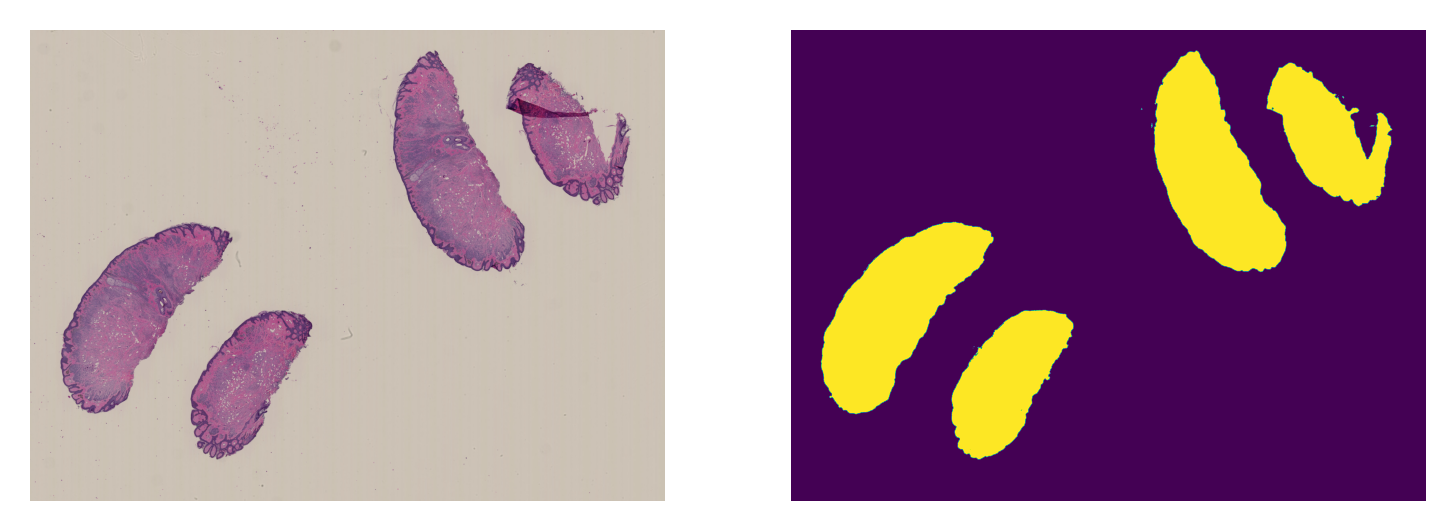

In [37]:
# [Loading the raw prediction]
print('prediction method output is: {}'.format(tissue_mask_output))
mini_wsi_prediction_raw = np.load(tissue_mask_output[0][1]+'.raw.0.npy') # Loading the first prediction [0] based on the output address [1]
print('Raw prediction dimensions: {}'.format(mini_wsi_prediction_raw.shape))

# [Post-processing]
# Simple processing of the raw prediction to generate semantic segmentation task
mini_wsi_prediction = np.argmax(mini_wsi_prediction_raw, axis=-1) # select the class with highest probability
print('Processed prediction dimensions: {}'.format(mini_wsi_prediction.shape))

# [WSI overview extraction]
# Now reading the WSI to extract it's overview
mini_wsi = get_wsireader(mini_wsi_file_name)
print('WSI original dimensions: {}'.format(mini_wsi.info.level_dimensions[0]))

# using the prediction save_resolution to create the wsi overview at the same resolution
overview_info = {'units': 'mpp', 'resolution': 8.0} # same as save_resolution

# extracting slide overview using `slide_thumbnail` method
mini_wsi_overview = mini_wsi.slide_thumbnail(resolution=overview_info['resolution'], units=overview_info['units'])
print('WSI overview dimensions: {}'.format(mini_wsi_prediction.shape))

ax = plt.subplot(1, 2, 1), plt.imshow(mini_wsi_overview); plt.axis('off')
ax = plt.subplot(1, 2, 2), plt.imshow(mini_wsi_prediction); plt.axis('off')

And that's it!

To once again see how easy it is to use an external model in Tiatoolbox semantic segmentation class to do inference on a set of images/WSIs, let summarize what we have been saying so far in a pseudo-code, as below:
```
# 1- Define the Pytorch model and load weights
model = get_CNN()
model.load_state_dict(pretrained_weights) 

# 2- Define the segmentor and IOconfig
segmentor = SemanticSegmentor(model)
ioconfig = IOSegmentorConfig(...)

# 3- Run the prediction
output = tissue_segmentor.predict([img_paths], save_dir, ioconfig, ...)

```

Feel free to play around with the parameters, models, and testing new images in this example. Currently, we are extending our collection of pre-trained models. To keep a track of them, make sure to follow our releases and [here](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/data/pretrained_model.yaml). We welcome any trained model in computational pathology (in any task) to be added to the Tiatoolbox. So if you have such a model (in Pytorch) and want to contribute, please contact us or simply create a PR on our Github page.